In [1]:
import spotchaos.syntheticSignals as sp

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.animation import TimedAnimation
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import tqdm
import pickle
import os
from astropy.timeseries import LombScargle
from scipy.integrate import RK45, DOP853
from scipy.stats import chi2, iqr
from scipy.signal import argrelextrema, savgol_filter
from scipy.spatial.distance import chebyshev
from scipy.optimize import curve_fit

from pytisean import tiseano, tiseanio


TISEAN 3.0.1 (C) R. Hegger, H. Kantz, T. Schreiber (1998-2007)

lorenz: integration of the Lorenz system
opened /private/tmp/pytisean_temp_2022-10-17-16-20-22_4j_pfpb9/outFile for output
 Lorenz trajectory covering   50.0000000      time units

 Lyapunov exponents [1/unit time]
  0.912967026    
   1.28864739E-02
  -14.5925198    



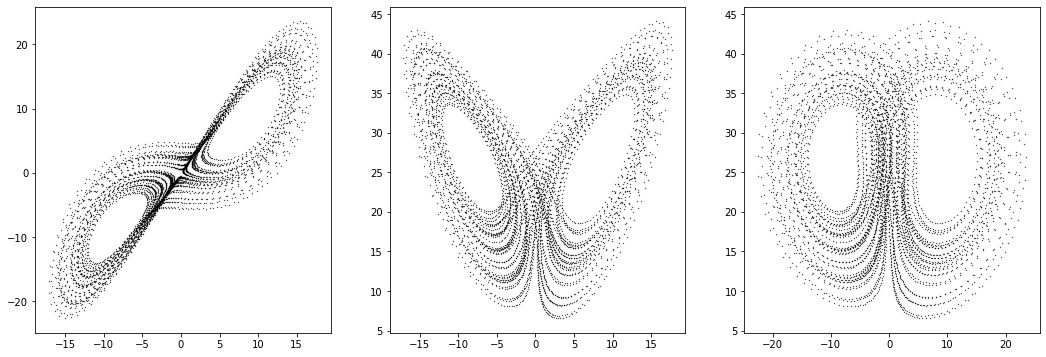

Time taken = 14.537882804870605 s


In [2]:
tstart = time.time()
# Generate 5000 iterates of the henon map
# lorenz -l# [-f# -r# -R# -S# -B# -o outfile -x# -V# -h]
# required argument: -l = "irun" [steps], length of time series to produce
# optional argumens: -f = "isamp" [steps/time unit], the number of steps per time unit. default = 100.
#                    -x = "itrans" [steps * time] , default = 100, length of "transient" (presumably to discard at beginning of time series). 
#                                            this is immediately reassigned as itrans = real(itrans)/dh, where dh = 0.0005 [time] is the 
#                                            "step width of RK integration". itrans then has units of steps.
#                                            
#                                    
# "total time" to run (i.e. the value of "time units the trajectory covers", see print statement during runtime) is totaltime = real(irun)/real(isamp)
# "istep" = 1./dh/isamp = [1/time]/[steps/time] = [1/steps]

# covering "" time units = -l / -f
tisean_lorenz, msg = tiseano('lorenz', '-l5000', '-x0')

fig, axes = plt.subplots(1, 3, figsize=(18,6))
axes[0].scatter(tisean_lorenz[:, 0], tisean_lorenz[:, 1], color='k', s=0.1)
axes[1].scatter(tisean_lorenz[:, 0], tisean_lorenz[:, 2], color='k', s=0.1)
axes[2].scatter(tisean_lorenz[:, 1], tisean_lorenz[:, 2], color='k', s=0.1)

plt.show()
tend = time.time()
print("Time taken = {} s".format(tend - tstart))

In [3]:
print(type(tisean_lorenz))
print(np.shape(tisean_lorenz))

<class 'numpy.ndarray'>
(5001, 3)


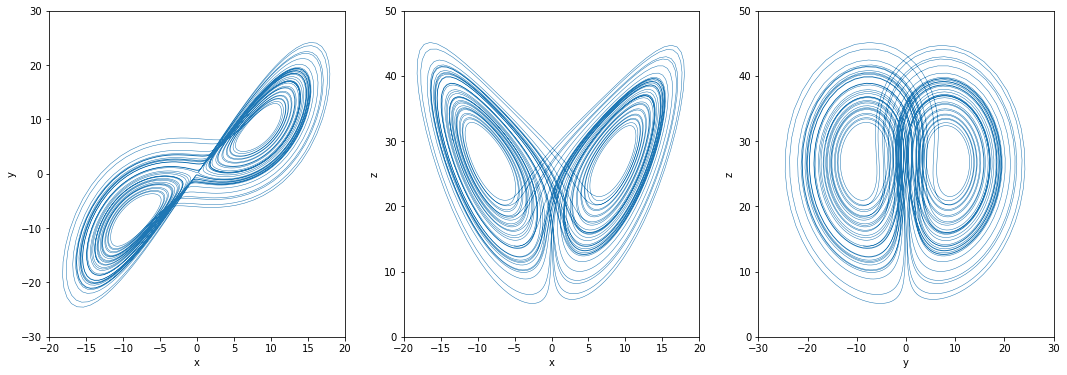

Time taken = 12.335133790969849 s


In [9]:
tstart = time.time()
#r0 = np.array((1., 1., 1.))
# the above IC isn't yet on the attractor, has a brief transient; the below is chosen as the 5000th iteration of the above
# and seems to be safely on the attractor
r0 = np.array((-13.29390985, -16.32060497,  29.90864944))

itrans = 0.#100
dt = 0.0005

itrans = int(itrans/dt)

irun = 5000
isamp = 100
totaltime = irun/isamp

istep = 1./dt/isamp
istep = int(istep)

tmin = 0.

lorenz_r = np.empty((irun,3))
lorenz_t = np.empty((irun))
lorenz = RK45(fun=sp.Lorenz_vel,t0=tmin,y0=r0,max_step=dt,t_bound=10000.)

for i in range(itrans):
    lorenz.step()

counter = 0
for i in range(irun*istep):
    lorenz.step()
    if i%istep==0:
        lorenz_t[counter] = lorenz.t
        lorenz_r[counter] = lorenz.y
        counter += 1

fig, axes = plt.subplots(1,3,figsize=(18,6))
axes[0].plot(lorenz_r[:,0],lorenz_r[:,1],lw=0.5)
axes[0].set_xlim(-20,20)
axes[0].set_ylim(-30,30)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].plot(lorenz_r[:,0],lorenz_r[:,2],lw=0.5)
axes[1].set_xlim(-20,20)
axes[1].set_ylim(0,50)
axes[1].set_xlabel("x")
axes[1].set_ylabel("z")
axes[2].plot(lorenz_r[:,1],lorenz_r[:,2],lw=0.5)
axes[2].set_xlim(-30,30)
axes[2].set_ylim(0,50)
axes[2].set_xlabel("y")
axes[2].set_ylabel("z")
plt.show()

tend = time.time()

print("Time taken = {} s".format(tend - tstart))


In [10]:
print(np.shape(tisean_lorenz[:,0]))
print(np.shape(lorenz_r[:,0]))

(5001,)
(5000,)


In [37]:
tdiff = lorenz_t[1:] - lorenz_t[:-1]
print(len(tdiff[tdiff > 0.01]))
print(len(tdiff[tdiff > 0.010000000001]))
#plt.hist(tdiff, range=(0.,0.02),bins=20)

2846
0


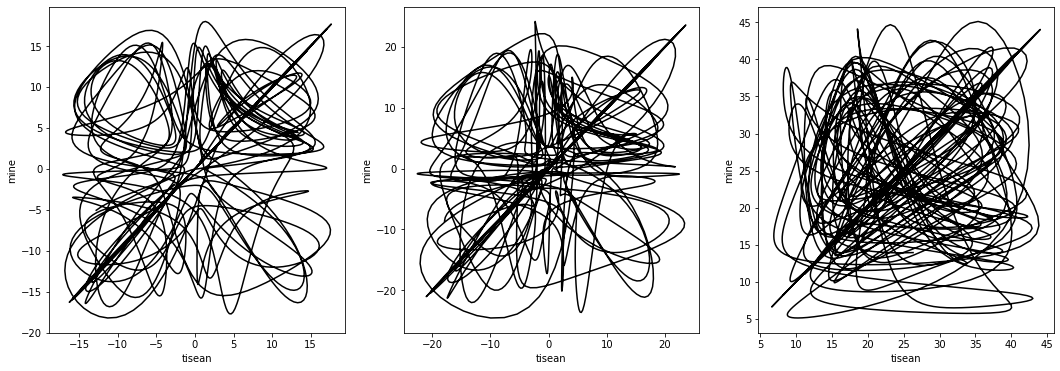

In [38]:
# Compare TISEAN to my implementation.

fig, axes = plt.subplots(1,3,figsize=(18,6))

for i in range(3):
    axes[i].plot(tisean_lorenz[0:-1,i], lorenz_r[:,i],'k-')
    axes[i].set_xlabel("tisean")
    axes[i].set_ylabel("mine")
    
plt.show()


1.0953298109585832


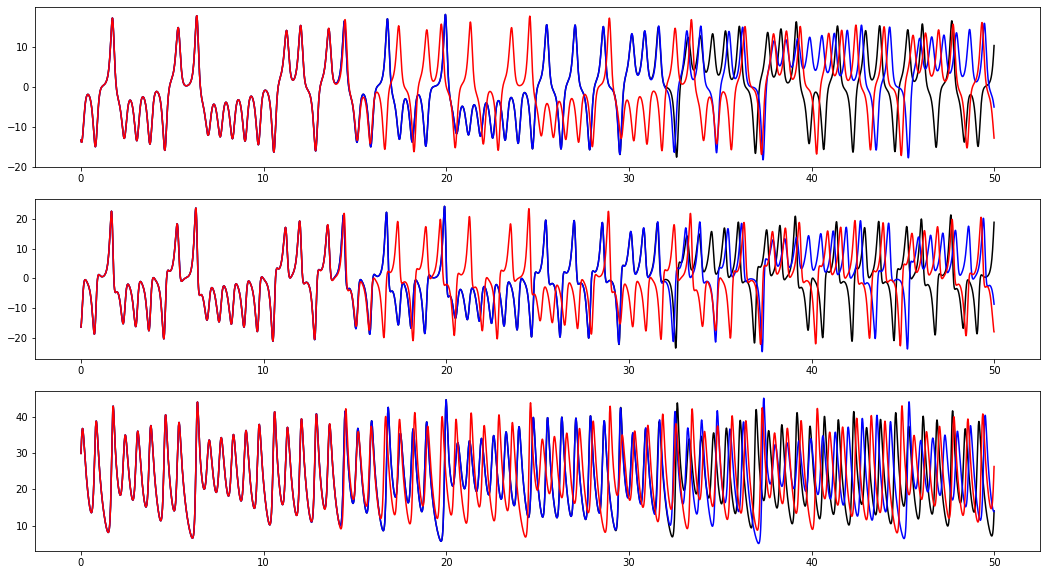

In [40]:
# Compare TISEAN to my implementation.

# positive lyapunov exponent calculated by TISEAN routine:
lyap =  0.912967026 #[1/time]
inv_lyap = 1./lyap

print(inv_lyap)

fig, axes = plt.subplots(3,1,figsize=(18,10))

axes[0].plot(lorenz_t_10,lorenz_r_10[:,0],'k-')
axes[0].plot(lorenz_t,lorenz_r[:,0],'b-')
axes[0].plot(lorenz_t_10,tisean_lorenz[:-1,0],'r-')

axes[1].plot(lorenz_t_10,lorenz_r_10[:,1],'k-')
axes[1].plot(lorenz_t,lorenz_r[:,1],'b-')
axes[1].plot(lorenz_t_10,tisean_lorenz[:-1,1],'r-')

axes[2].plot(lorenz_t_10,lorenz_r_10[:,2],'k-')
axes[2].plot(lorenz_t,lorenz_r[:,2],'b-')
axes[2].plot(lorenz_t_10,tisean_lorenz[:-1,2],'r-')

plt.show()


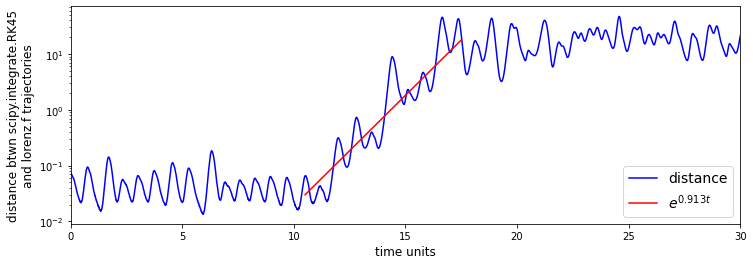

In [48]:
# relationship of lyapunov time to the above plots?

dist = np.linalg.norm(lorenz_r - tisean_lorenz[:-1],axis=1)

fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(lorenz_t, dist,'b-',label="distance")
ax.plot(lorenz_t[0:700]+10.5, 0.03*np.exp(lorenz_t[0:700]*lyap),'r-',label=r"$e^{0.913t}$")
ax.set_yscale("log")
ax.set_xlabel("time units",fontsize=12)
ax.set_ylabel("distance btwn scipy.integrate.RK45\nand lorenz.f trajectories",fontsize=12)
ax.set_xlim(0,30)
ax.legend(loc="lower right",fontsize=14)
#plt.show()
plt.savefig("./scipy_vs_fortran_lorenzintegration.png")